In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable, Function
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
bs = 100 #batch size

# MNIST Dataset
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])])

source_train_dataset =  datasets.SVHN(root='../data/', split='train', transform=transform, download=True)
source_test_dataset =  datasets.SVHN(root='../data/', split='train', transform=transform, download=True)

# Data Loader (Input Pipeline)
source_train_loader = torch.utils.data.DataLoader(dataset=source_train_dataset, batch_size=bs, shuffle=True)
source_test_loader = torch.utils.data.DataLoader(dataset=source_train_dataset, batch_size=bs, shuffle=True)


target_train_dataset = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
target_test_dataset = datasets.MNIST(root='../data/',  train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
target_train_loader = torch.utils.data.DataLoader(dataset=target_train_dataset, batch_size=bs, shuffle=True)
target_test_loader = torch.utils.data.DataLoader(dataset=target_test_dataset, batch_size=bs, shuffle=True)



  0%|          | 0/182040794 [00:00<?, ?it/s]

Using downloaded and verified file: ../data/train_32x32.mat


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.fc1 = nn.Linear(32*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
      
           
    def forward(self, x):
                x=self.conv1(x)
                x=F.max_pool2d(x, 2 ,2)
                x = F.leaky_relu(x)
                
                x=self.conv2(x)
                x=F.max_pool2d(x, 2 ,2)
                x = F.leaky_relu(x)
                x= x.view(-1,32*4*4)
                
                x=self.fc1(x)
                x = F.leaky_relu(x)
                
                x=self.fc2(x)
                x = F.leaky_relu(x)
                
                x=self.fc3(x)
                
                
                return F.log_softmax(x,-1)

In [ ]:

def train(epoch,train_loader):
    for batch_id, (data, label) in enumerate(train_loader):
        clf.train()
        data=data.cuda()
        label=label.cuda()
        opt.zero_grad()
        preds = clf(data)
        loss = torch.diag(preds[:,label])
        loss =  -torch.mean(loss)
        loss.backward()
        opt.step()
        predind = preds.data.max(1)[1] 
        acc = predind.eq(label.data).cpu().float().mean() 
        if batch_id % 100 == 0:
            print("Train Loss: "+str(loss.item())+" Acc: "+str(acc.item()))

        
def test(epoch,test_loader):      
    #run independent test
    clf.eval() # set model in inference mode (need this because of dropout)
    test_loss = 0
    correct = 0

    for data, target in test_loader: 
        data=data.cuda()
        target=target.cuda()  
        with torch.no_grad():    
            output = clf(data)
            test_loss += F.nll_loss(output, target).item()
            pred = output.data.max(1)[1] 
            correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    accuracy =  correct.item() / len(test_loader.dataset)
    print("Test Loss: "+str(test_loss)+" Acc: "+str(accuracy))


In [ ]:
clf = CNNClassifier()
clf.cuda()
opt = optim.Adam(clf.parameters())
               
for epoch in range(0, 3):
    print("Epoch %d" % epoch)
    train(epoch,source_train_loader)
    test(epoch,source_test_loader)

Epoch 0
Train Loss: 2.2911593914031982 Acc: 0.23000000417232513
Train Loss: 1.5709176063537598 Acc: 0.5
Train Loss: 1.2271599769592285 Acc: 0.6800000071525574
Train Loss: 0.7371314764022827 Acc: 0.75
Train Loss: 0.6696247458457947 Acc: 0.800000011920929
Train Loss: 0.6555185317993164 Acc: 0.8100000023841858
Train Loss: 0.63265460729599 Acc: 0.7900000214576721
Train Loss: 0.5251939296722412 Acc: 0.8199999928474426
Test Loss: 0.49781098636566046 Acc: 0.8524373097451438
Epoch 1
Train Loss: 0.45736098289489746 Acc: 0.8600000143051147
Train Loss: 0.37503358721733093 Acc: 0.8799999952316284
Train Loss: 0.5389060974121094 Acc: 0.8600000143051147
Train Loss: 0.5013972520828247 Acc: 0.8700000047683716
Train Loss: 0.38457274436950684 Acc: 0.8600000143051147
Train Loss: 0.6023612022399902 Acc: 0.8500000238418579
Train Loss: 0.39292478561401367 Acc: 0.8799999952316284
Train Loss: 0.42784181237220764 Acc: 0.8700000047683716
Test Loss: 0.3725323538419169 Acc: 0.889580517902726
Epoch 2
Train Loss: 0.

(100, 1, 28, 28)


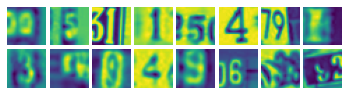

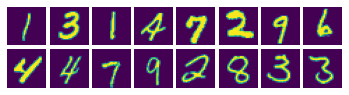

In [ ]:
def imshow_grid(images, shape=[2, 8]):
    """Plot images in a grid of a given shape."""
    fig = plt.figure(1)
    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.05)

    size = shape[0] * shape[1]
    for i in range(size):
        grid[i].axis('off')
        grid[i].imshow(images[i])  # The AxesGrid object work as a list of axes.

    plt.show()
source_train_dataset_array = next(iter(source_train_loader))[0].numpy()
source_train_labels_array = next(iter(source_train_loader))[1].numpy()
target_train_dataset_array = next(iter(target_train_loader))[0].numpy()
target_labels_array_mnistm = next(iter(target_train_loader))[1].numpy()
print(source_train_dataset_array.shape)
imshow_grid((source_train_dataset_array[:16,0,:,:]+1)/2)
imshow_grid((target_train_dataset_array[:16,0,:,:]+1)/2)

In [ ]:
test(epoch,target_test_loader)

Test Loss: 2.410429284572601 Acc: 0.5659
